# P2S: A* and Sample-Based Planning

[Instructions are the same as last time.]

You are *highly recommended* to LaTeX your solutions to this assignment and use the 10pt, 2-column `ieeeconf` template. You can find the template [on Overleaf](https://www.overleaf.com/latex/templates/preparation-of-papers-for-ieee-sponsored-conferences-and-symposia/zfnqfzzzxghk); Overleaf is an online LaTeX editor with a free tier, so feel free to use that service to compose your writeups. It is perhaps the easiest option, particularly if you are not as familiar with LaTeX. While there is no space limit, please try to keep your plots compact so that they do not consume an enormous amount of space; mostly this helps readability (and therefore grading). You are allowed to work in small groups (2 or 3 students), but your solutions and your writeup should be your own.

With these homework assignments, I expect that your solutions will be written as if they are research papers: though the content is not "new", you should be trying to convince me through your writing that you have implemented and understand the algorithms. You should write in full sentences. When appropriate, comment on when the algorithms succeed or fail and where they are more or less effective; include numbers/metrics (quantitative) in addition to discussion (qualitative) whenever possible. Just like in a published paper, you should not include code snippets in your writeup unless it is explicitly asked for or you think it helps you explain your results or answer the question. **I will ask you to submit both the PDF of your writeup *and* a .zip file containing your code (which may be a modified form of this Jupyter notebook) on Blackboard. Unless asked, do not include code in your writeup. You should present your results well enough that I trust your implementation was sufficient.** Though it would be nice if your code were cleaned up and nicely formatted/commented, we will are only likely to run your code to evaluate partial credit or unless we are skeptical for academic integrity reasons.

You are welcome to work in small groups of 2 or 3 students, but please write your solutions independently: I would like your answers to the more conceptual questions to be in your own words, even if you discussed the answers with others.

You will be graded on your included plots and answers to conceptual questions. Your code will not be directly graded or evaluated. You can receive partial credit on pretty much everything, and I try to be a fair as possible: giving you a grade that I think reflects your level of understanding of the material. Note that while I appreciate you submitting plots that you *know* are probably not quite right, it can be hard for me to evaluate partial credit if things are not quite working; in this case, try to include in your response a guess of where you think your solution didn't work. This will help me know when to give you more credit on your responses.

## P2.1: A* for Sliding Puzzles

For this question you'll be once again exploring the Sliding Puzzle, which you first encountered in your last programming assignment. I have provided the implementation again here as starter code; you are referred to Programming Assignment P1 for some examples of the `SlidingPuzzle` implementation, which will not be reproduced here.

### Make the code smaller

In [40]:
# Sliding Puzzle Implementation (starter/utility code)

import matplotlib.pyplot as plt
import numpy as np
import random


class SlidingPuzzle(object):
    def __init__(self, nrows=3, ncols=3, state=None):
        self.nrows = nrows
        self.ncols = ncols
        if state is None:
            self.state = np.array(list(range(1, nrows * ncols)) + [0])
        else:
            self.state = state
            
    def randomize(self, num_iterations=100):
        rand_puzzle = self
        for _ in range(num_iterations):
            rand_puzzle = random.choice(rand_puzzle.get_children())
        self.state = rand_puzzle.state
        return self
    
    def get_swapped_puzzle(self, zero_ind, swap_ind):
        state = self.state.copy()
        state[zero_ind], state[swap_ind] = state[swap_ind], state[zero_ind]
        return SlidingPuzzle(nrows=self.nrows,
                             ncols=self.ncols,
                             state=state)
        
    def get_children(self):
        ind = np.argwhere(self.state == 0)[0, 0]
        swap_inds = []
        ncols = self.ncols
        
        if ind - self.ncols >= 0:
            swap_inds.append(ind - ncols)
        if ind + self.ncols < self.nrows * self.ncols:
            swap_inds.append(ind + ncols)
        if ((ind - 1) // self.ncols) == ((ind) // self.ncols):
            swap_inds.append(ind - 1)
        if ((ind + 1) // self.ncols) == ((ind) // self.ncols):
            swap_inds.append(ind + 1)

        return [self.get_swapped_puzzle(ind, sind) for sind in swap_inds]

    def print(self):
        print(np.reshape(self.state, (self.nrows, self.ncols)))
        
    def get_reshaped_state(self):
        return np.reshape(self.state, (self.nrows, self.ncols))

    def __eq__(self, other):
        return len(self.state) == len(other.state) and (self.state == other.state).all()

    def __str__(self):
        return str(self.get_reshaped_state())

    def __hash__(self):
        return hash(tuple(self.state))
    
    def plot_puzzle(self):
        reshaped_state = self.get_reshaped_state()
        plt.imshow(reshaped_state)
        
        # From: https://stackoverflow.com/a/33829001
        for (j,i),label in np.ndenumerate(reshaped_state):
            plt.text(i,j,label,ha='center',va='center')
            plt.text(i,j,label,ha='center',va='center')
        
        plt.gca().xaxis.set_ticks([])
        plt.gca().yaxis.set_ticks([])

## P2.1.1: Implementing A* Search

Below, I have provided you with some starter code for A* search. The code relies on the `SortedList` class from the `sortedcontainers` (if this is not installed, you may need to run `pip3 install sortedcontainers` at the command line).

**TASK** Complete A* search below.

To confirm that your code is working, run the code block that follows for a 4x2 puzzle.

**QUESTION** (1-2 sentences) The code block to check your A* starch uses a heuristic function I have provided you with, `sliding_puzzle_zero_heuristic`, that returns 0 no matter the inputs. Is this an admissible heuristic? Explain why or why not?

In [41]:
# Starter Code: stub of A* search
from sortedcontainers import SortedList
import time

def astar_search(start, goal, heuristic_fn, max_iterations=100000):
    # Cost function: distance from start (q[0]) + heuristic cost (q[1])
    cost_fn = lambda q: q[0] + q[1]
    stime = time.time()
    # Q is a "sorted list" of tuples:
    #  (dist from start, heuristic, list of states in current 'branch')
    Q = SortedList([(0, heuristic_fn(start, goal), [start])], key=cost_fn)
    # print(Q)
    visited = set()
    for ind in range(max_iterations):
        # This gets N with the smallest value of cost_fn and removes it from Q
        N = Q.pop(0)
        
        # Split up N (for convenience)
        distN, hN, statesN = N
        
        # Check if the goal has been reached
        if statesN[-1] == goal:
            return {
                'succeeded': True,
                'path': statesN,
                'num_iterations': ind,
                'path_len': len(statesN),
                'num_visited': len(visited),
                'time': time.time() - stime,
            }
        
        # Then add new paths to Q from N (and its children)
        if not (statesN[-1] in visited):
          visited.add(statesN[-1])
          children = statesN[-1].get_children()
          for child in children:
            path = statesN.copy()
            if not (child in visited):
              distN1 = distN + 1
              hN1 = heuristic_fn(child, goal)
              # print(child.state)
              path.append(child)
              Q.add((distN1, hN1, path))
              # print(Q)
        # Note: to add to Q use 'Q.add((...))'   
    return {'succeeded': False}


def print_astar_results(plan_dat, heuristic_name):
    print(f"A* {heuristic_name} Time: {plan_dat['time']}")
    print(f"A* {heuristic_name} Path Len: {plan_dat['path_len']}")
    print(f"A* {heuristic_name} NumIterations: {plan_dat['num_iterations']}")


def sliding_puzzle_zero_heuristic(start, goal):
    return 0

In [4]:
# Check that your A* implementation reaches the goal.
random.seed(696)
goal = SlidingPuzzle(nrows=4, ncols=2)
puzzle = SlidingPuzzle(nrows=4, ncols=2).randomize()

print("Starting puzzle:")
print(puzzle)
print()

plan_zero_heuristic = astar_search(puzzle, goal, sliding_puzzle_zero_heuristic)
print_astar_results(plan_zero_heuristic, 'No Heuristic')

Starting puzzle:
[[7 1]
 [2 4]
 [6 5]
 [3 0]]

A* No Heuristic Time: 0.2750260829925537
A* No Heuristic Path Len: 21
A* No Heuristic NumIterations: 5079


### P2.1.2 Heuristics for the Sliding Puzzle

In class we discussed two different heuristics the *number of incorrect tiles* heuristic and the *Manhattan distance* heuristic.

**TASK** Implement both heuristics and run the code block that follows. I have included some starter code for your convenience in the code block following this one.

In addition to your two heuristics, I have created two additional heuristics that are the square of yours. The code "results" code below solves an example puzzle using all four heuristics. Run that code and observe the results.

**RESULTS** Include in your writeup the results for all 4 heuristics, including the amount of time, number of iterations, and path length.

**QUESTION** (2-4 sentences) Which of your two heuristics (not the squared one I provided you with) reaches the goal in fewer iterations. Will this be true (or at least close enough) for any puzzle? Explain why.

**QUESTION** (3-5 sentences) Which of the four heuristics are admissible? What happens when you use a non-admissible heuristic to plan? How do the path lengths compare between the admissible and the non-admissible heuristics? How do the number of iterations compare between your heuristics and the "squared" versions I provided you with? Why does this happen?

#### Heuristic functions

In [42]:
def sliding_puzzle_heuristic_num_incorrect(start, goal):
    state1 = start.state - goal.state
    # get the number of incorrect position (state1's value is !=0)
    return len(np.argwhere(state1))

def get_position(value, ncolns, nrows):
  x = 0
  y = 0
  z1 = value % nrows
  if z1 == 0:
    x = ncolns
    y = value // nrows 
  else: 
    x = z1
    y = value // nrows + 1
  return np.array([x, y])


def sliding_puzzle_heuristic_manhattan(start, goal):
  man_dist = 0
  for ii in range(len(start.state)):
    if not (start.state[ii] == 0):
      goal_pos = get_position(start.state[ii], start.ncols, start.nrows)
      current_pos = get_position(ii+1, start.ncols, start.nrows)
      delta = goal_pos - current_pos
      man_dist += np.abs(delta[0]) + np.abs(delta[1])
  return man_dist

#### Test algorithms

In [77]:
# Results with different heuristics:
goal = SlidingPuzzle(nrows=3, ncols=3)
# puzzle = SlidingPuzzle(nrows=3, ncols=2)
puzzle = SlidingPuzzle(nrows=3, ncols=3).randomize()
# puzzle.state = np.array(((7, 1), (2, 4), (6, 5), (3, 0))).flatten()

print("Starting puzzle:")
print(puzzle)
print()

plan_zero_heuristic = astar_search(puzzle, goal, sliding_puzzle_zero_heuristic)
print_astar_results(plan_zero_heuristic, 'No Heuristic')
print()
plan_incorrect_heuristic = astar_search(puzzle, goal, sliding_puzzle_heuristic_num_incorrect)
print_astar_results(plan_incorrect_heuristic, 'Num Incorrect Heuristic')
print()
plan_incorrect_heuristic = astar_search(puzzle, goal, sliding_puzzle_heuristic_manhattan)
print_astar_results(plan_incorrect_heuristic, 'Manhattan Distance Heuristic')
print()
plan_incorrect_heuristic = astar_search(
    puzzle, goal, lambda s, g: sliding_puzzle_heuristic_num_incorrect(s, g) ** 2)
print_astar_results(plan_incorrect_heuristic, 'Num Incorrect Squared Heuristic')
print()
plan_incorrect_heuristic = astar_search(
    puzzle, goal, lambda s, g: sliding_puzzle_heuristic_manhattan(s, g) ** 2)
print_astar_results(plan_incorrect_heuristic, 'Manhattan Squared Heuristic')

Starting puzzle:
[[8 1 3]
 [5 0 6]
 [2 4 7]]

A* No Heuristic Time: 0.8298060894012451
A* No Heuristic Path Len: 17
A* No Heuristic NumIterations: 14229

A* Num Incorrect Heuristic Time: 0.0555872917175293
A* Num Incorrect Heuristic Path Len: 17
A* Num Incorrect Heuristic NumIterations: 682

A* Manhattan Distance Heuristic Time: 0.02445197105407715
A* Manhattan Distance Heuristic Path Len: 17
A* Manhattan Distance Heuristic NumIterations: 129

A* Num Incorrect Squared Heuristic Time: 0.02234482765197754
A* Num Incorrect Squared Heuristic Path Len: 19
A* Num Incorrect Squared Heuristic NumIterations: 265

A* Manhattan Squared Heuristic Time: 0.06731057167053223
A* Manhattan Squared Heuristic Path Len: 33
A* Manhattan Squared Heuristic NumIterations: 408


## P2.2: Monte Carlo Sampling

Next, we'll transition to thinking about *sampling-based planning*. A prerequisite to that is understanding how sampling can be used to approximately solve problems of interest to us that improve as we continue to sample. This problem is a prerequisite for the next two.

### P2.2.1: Computing Area with MC Sampling

In the code below I have provided you with some simple functions to make two different sets of obstacles (and plot them): (1) in which there is only a single rectangular obstacle, and (2) in which there are multiple obstacles. You may use the `shapely` package to check whether or not an obstacle contains a point; here's an example:

```python
from shapely.geometry import Point
point = [5.0, 2.0]
is_inside_obstacle = obstacle.contains(Point(point[0], point[1]))
```

**TASK** Complete the starter code below to approximately compute the area contained within the two environments.

**PLOTS** Include a two plots (one for each environment), showing the points that were inside and outside the different obstacles (after 2500 samples).

**RESULTS/QUESTION** (2-3 sentences) Compute the area for both environments after 100, 1000, 10000, and 100000 samples and include them in your writeup. For the square environment, how does the accuracy of the measurement (compared to the true value) compare as a function of the number of samples?

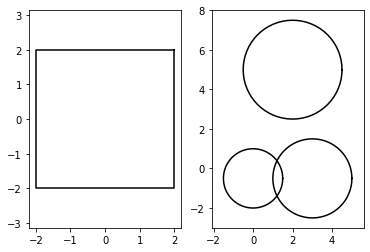

In [7]:
# Starter code for P2.2.1
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

def plot_env(obstacles):
    for poly in obstacles:
        plt.plot(*poly.exterior.xy, 'k')

    plt.gca().axis('equal')

env_square = [Point(0, 0).buffer(2.0, cap_style=3)]
env_multi = [
    Point(0, -0.5).buffer(1.5),
    Point(3, -0.5).buffer(2.0),
    Point(2, 5).buffer(2.5),
]

region_x = [-5, 5]
region_y = [-5, 5]

plt.figure()
plt.subplot(121)
plot_env(env_square)
plt.subplot(122)
plot_env(env_multi)

None

In [8]:
# Sample points and determine which of them fall inside the circle.
import random
from shapely.geometry import Point

def sample_points_in_region(region_x, region_y, obstacles, num_iterations):

    points_inside = []
    points_outside = []

    for _ in range(num_iterations):
      # Randomly generate a point and check for inclusion
      x = random.uniform(region_x[0], region_x[1])
      y = random.uniform(region_y[0], region_y[1])
      # check whether a point is inside the obstacles
      contain = False
      for obs in obstacles:
        if obs.contains(Point(x, y)):
          contain = True
      
      if contain:
        points_inside.append([x,y])
      else:
        points_outside.append([x,y])

    return points_inside, points_outside

Num points inside env_multi: 172
Num points outside env_multi: 828
Num points total env_multi: 1000
Num points inside env_square: 70
Num points outside env_square: 930
Num points total env_square: 1000


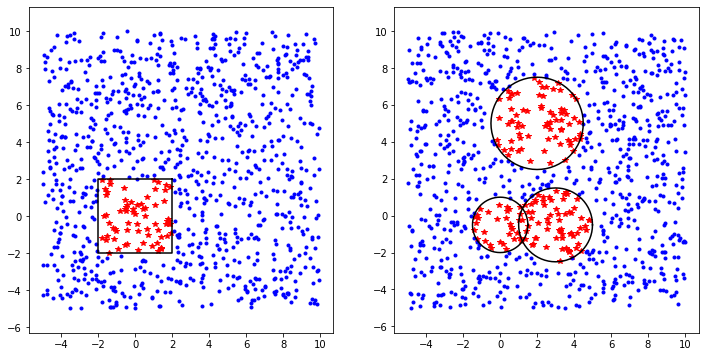

In [9]:
# Plotting starter code
point_inside1, point_outside1 = sample_points_in_region([-5, 10], [-5, 10], env_square, 1000)
point_inside2, point_outside2 = sample_points_in_region([-5, 10], [-5, 10], env_multi, 1000)

# Print the number inside/outside
print(f"Num points inside env_multi: {len(point_inside2)}")
print(f"Num points outside env_multi: {len(point_outside2)}")
print(f"Num points total env_multi: {len(point_inside2) + len(point_outside2)}")

# Print the number inside/outside
print(f"Num points inside env_square: {len(point_inside1)}")
print(f"Num points outside env_square: {len(point_outside1)}")
print(f"Num points total env_square: {len(point_inside1) + len(point_outside1)}")

# plt.figure()

plt.figure(figsize=(12, 6))
plt.subplot(121)
pin1 = np.array(point_inside1)
plt.plot(pin1[:, 0], pin1[:, 1], 'r*')
pout1 = np.array(point_outside1)
plt.plot(pout1[:, 0], pout1[:, 1], 'b.')
plot_env(env_square)


plt.subplot(122)
# plt.figure(figsize=(6, 6))
pin2 = np.array(point_inside2)
plt.plot(pin2[:, 0], pin2[:, 1], 'r*')
pout2 = np.array(point_outside2)
plt.plot(pout2[:, 0], pout2[:, 1], 'b.')
plot_env(env_multi)

## P2.2.2: More MC Sampling 

Now we'll use a sampling approach to compute something that isn't merely area, and can be much more difficult to compute exactly. Now answer the following question: *What is the likelihood that a random unit-length line (of random orientation) contained within `x=[-1, 1]` and `y=[-1, 1]` does not intersect a box centered at the origin with side length 1?*

There are a number of things to consider in this question:
- How do we generate a random unit line? There are a number of approaches, though the one I might recommend is to (1) pick a random point within in `x=[-1, 1]` and `y=[-1, 1]`, (2) connect it to another point 1 unit away at along a random direction and then (3) throw it away (and repeat) if it does not. I have provided you with a function `get_random_line` that does this.
- How do we decide if the line intersects with the box? For this you can use Shapely again. Here is an example of checking whether a line intersects a box:

```python
from shapely.geometry import LineString
line = LineString([point_a, point_b])
does_intersect = line.intersects(obstacle)
```

**TASK** Complete the starter `does_line_collides` code below and use it (with a sampling approach) to answer the question above.

**PLOT** Use your code to generate 100 random lines within the specified region that avoid the side-length-1 square at the center. Your plotting code will look something like this:

```python
for line in accepted_lines[:100]:
    l = np.array(line)
    plt.plot(l[:, 0], l[:, 1])
    if does_line_collide(line, env_center_square):
        plt.plot(l[:, 0], l[:, 1], 'r')
```

**RESULT** Include in your writeup the answer to the question above: *What is the likelihood that a random unit-length line (of random orientation) contained within `x=[-1, 1]` and `y=[-1, 1]` does not intersect a box centered at the origin with side length 1?* [Try using >=10000 iterations] To answer this question, generate a *ton* of random lines and compute what percentage of them do not intersect with the box.

In [10]:
# Starter code for line intersection
from shapely.geometry import LineString

env_center_square = [Point(0, 0).buffer(0.5, cap_style=3)]

def get_random_line(region_x, region_y):
    px = random.uniform(region_x[0], region_x[1])
    py = random.uniform(region_y[0], region_y[1])
    point_a = [px, py]

    theta = random.uniform(0, 2 * np.pi)
    point_b = [px + np.cos(theta), py + np.sin(theta)]
    if point_b[0] < region_x[0] or point_b[0] > region_x[1]:
        return get_random_line(region_x, region_y)
    if point_b[1] < region_y[0] or point_b[1] > region_y[1]:
        return get_random_line(region_x, region_y)
    return [point_a, point_b]

def does_line_collide(line, obstacles):
  no_collide = True
  for obs in obstacles:
    if line.intersects(obs):
      no_collide = False
  return no_collide

def probability_of_line_obs_no_collide(region_x, region_y, obstacles, num_iterations):
    collide = []
    no_collide = []
    for _ in range(num_iterations):
      # Randomly generate a line and check for collision
      two_points = get_random_line(region_x, region_y)
      line = LineString([two_points[0], two_points[1]])
      # check whether the line collide the obstacles
      if does_line_collide(line, obstacles):
        no_collide.append(line)
      else:
        collide.append(line)
    return no_collide, collide

The probability of no-collision:
0.2295


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work 

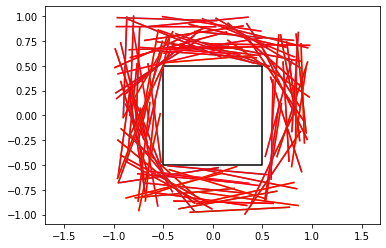

In [11]:
x=[-1, 1]
y=[-1, 1]
print("The probability of no-collision:")
no_collide, collide = probability_of_line_obs_no_collide(x, y, env_center_square , 20000)
print(len(no_collide)/(len(no_collide)+len(collide)))
# print(len(no_collide)/len(collide))
plot_env(env_center_square)
for line in no_collide[:100]:
    l = np.array(line)
    plt.plot(l[:, 0], l[:, 1])
    if does_line_collide(line, env_center_square):
        plt.plot(l[:, 0], l[:, 1], 'r')

## P2.3: Probabilistic Road Maps

Now that you have some idea of how to randomly sample points within an environment, let's try to use them to navigate! In this question, you will be building a simple implementation of a Probabilistic Road Map (PRM). The skeleton of how building and planning with a PRM works is as follows:

1. Generate random points (`num_points` of them) throughout the environment. Those points are the nodes in your graph.
2. For each point, find its neighbors (other points within a certain distance `max_edge_length`) and add edges to the graph.
3. Plan through the graph. In the Results/Plotting code below, I have provided you with a scipy function that computes the plan (and plots it) using the `edge_length_matrix` that your code should compute.

In this question, we will represent our graph as a list of points (`points`) and a matrix that stores the edge length (`edge_length_matrix`), where entries of value `0` indicate that no edge exists between the points.

**TASK** Complete the PRM implementation by resolving the `NotImplementedError` below.

**PLOT** Build the PRM graph for `num_sampled_points = 300` and plot the graph and its solution (using the plotting code I have provided you with below). Include this plot in your writeup.

**RESULTS+PLOT** Write a function that computes the length of the path between the start and the goal, as computed by the PRM. Compute the path length in the environment I have provided as a function of num_iterations (from 100 to 2500 in increments of 100 points). Plot path length vs num_iterations and include that plot in your writeup. [Note(1): be sure to fix your random seed between runs! The path length should (approximately) monotonically decrease.] [Note(2): Running the code below is much faster without plotting the entire PRM. Feel free to disable any and all plotting code to compute these values.] If no feasible plan exists, feel free to use a cost of 0.

**QUESTION** (2-3 sentences) In your results, you should notice a distinct "drop" at one or two places in the curve of path length versus num_iterations. Why do these drops occur? Feel free to include pictures if you feel they can help you answer the question.

In [12]:
# Starter code: Build the PRM graph

def plot_env(start, goal, obstacles):
    for poly in obstacles:
        plt.plot(*poly.exterior.xy, 'k')
    
    plt.plot(start[0], start[1], 'b.')
    plt.plot(goal[0], goal[1], 'g*')

    plt.gca().axis('equal')


env_multi = [
    Point(0, -0.5).buffer(1.5, cap_style=3),
    Point(3, 0).buffer(2.0, cap_style=3),
    Point(2, 5).buffer(2.5, cap_style=3),
]


def build_prm_graph(start, goal, region_x, region_y, obstacles1, max_distance, num_sampled_points):
    """
    returns: points, edge_length_matrix
    """
    # Initialize the points list and append 
    points = []
    points.append(start)
    points.append(goal)

    for _ in range(num_sampled_points):
        # Randomly generate points and add them to points
        x = random.uniform(region_x[0], region_x[1])
        y = random.uniform(region_y[0], region_y[1])
        # check whether a point is inside the obstacles
        inside = False
        for obs in obstacles1:
          if obs.contains(Point(x, y)):
            inside = True
        if not inside:
          points.append([x,y])

    # Initialize the "edge length graph"
    edge_length_matrix = np.zeros((len(points), len(points)))

    # Loop through all points, get their neighbors and test for collision with the environment.
    # You can use a double for-loop for this question (outer loop for the points and an 
    # inner loop to get the neighbors), though there are *way* faster ways to do this.
    for ii, point_a in enumerate(points):
        for jj, point_b in enumerate(points[ii+1:]):
            # reject (continue) if the points are within the max distance
            # calculating Euclidean distance
            p1 = point_a[0] - point_b[0]
            p2 = point_a[1] - point_b[1]
            dist = np.sqrt(np.square(p1) + np.square(p2))
            # dist = np.linalg.norm(points[ii] - points[jj])
            if dist <= max_distance:   
              # Collision check: if the line between the points collides with the geometry, continue.
              line1 = LineString([points[ii], points[jj]])
              no_collide1 = does_line_collide(line1, obstacles1)
              if no_collide1:       
                # Update the edge_length_matrix
                edge_length_matrix[ii, jj+ii+1] = dist
                edge_length_matrix[jj+ii+1, ii] = dist
        
    return points, edge_length_matrix

The path length is:  13.564508172088079


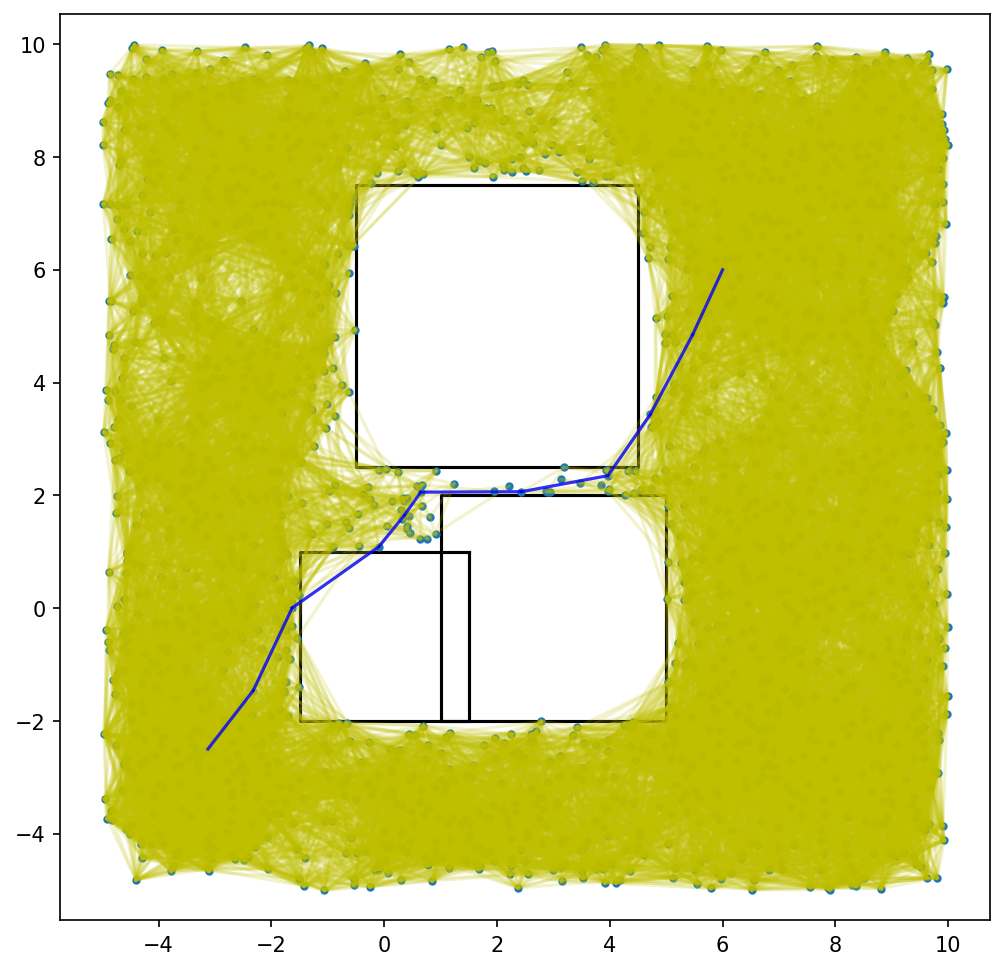

In [39]:
# Results & Plotting & Planning Code: PRM
random.seed(695)

# Parameters:
num_sampled_points = 2400
max_distance = 2.0
start = [-4, -4]
goal = [6, 6]
region_x = [-5, 10]
region_y = [-5, 10]
plt.figure(figsize=(8, 8), dpi=150)
# Plot the environment
plot_env(start, goal, env_multi)

points, edge_lengths = build_prm_graph(start, goal, region_x, region_y,
                                       env_multi, max_distance, num_sampled_points)
# Plot the points
np_points = np.array(points)
plt.plot(np_points[:, 0], np_points[:, 1], '.')

# Plot the edges between the points
for ii, point_a in enumerate(points):
    for jj, point_b in enumerate(points[ii+1:]):
        if edge_lengths[ii, jj+ii+1] > 0:
            plt.plot([point_a[0], point_b[0]],
                     [point_a[1], point_b[1]],
                     'y', alpha=0.2)

#  Plan and visualize the plan
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

dist_matrix, predecessors = shortest_path(csgraph=edge_lengths, method='D', directed=False, indices=0, return_predecessors=True)
prev_ind = 1
counter = 0
distance = 0
did_reach_goal = True
while counter < num_sampled_points:
    point_ind = predecessors[prev_ind]
    if point_ind == 0:
        did_reach_goal = True
        break
    if point_ind < 0:
        did_reach_goal = False
        break
    point_a = points[prev_ind]
    point_b = points[point_ind]
    distance += edge_lengths[prev_ind, point_ind]
    plt.plot([point_a[0], point_b[0]],
             [point_a[1], point_b[1]],
             'b', alpha=0.8)
    
    prev_ind = point_ind
    
    counter += 1

if not did_reach_goal:
    raise ValueError("Did not reach goal")
else:
  print("The path length is: ", distance)

## P2.4: RRT and RRT*

### P2.4.1 Building a (random) chain

In this question, you will familiarize yourself with some of the basics of using random sampling to incrementally build a path (as opposed to PRM, an "offline" approach). 
The code below relies on a `Link` class, that is defined mostly by a single point (the end of the link) and an upstream link, which defines the earlier point to which that link is connected. These links can be used to create a Tree (a data structure with a single 'root' Link and 'branches' coming off of that). 
In the "random chain" code I provide you with below, the last link in the chain is randomly added to.

**QUESTION** (2-3 sentences) What does the function `steer_towards_point` do? How would this function need to change if the vehicle had dynamics (and could not simply move in the direction of the new point)?

**PLOTS** Run the "random chain" code below and observe the results. This should generate two plots (in a single figure). Include them in your writeup.

**QUESTION** (4-8 sentences) Describe the results and discuss the algorithmic properties of the algorithm. Is this planner *complete* (will it always eventually find a path to the goal)? Is it asymptotically optimal (will that path approach the shortest path in the limit of infinite samples)?

In [ ]:
import numpy as np
import random
from shapely.geometry import LineString

class Link(object):
    def __init__(self, point, upstream=None):
        self.point = point
        self.upstream = upstream
        if upstream is not None:
            self.geom_line = LineString([point, upstream.point])
            self.local_cost = upstream.get_distance(point)
        else:
            self.geom_line = None
            self.local_cost = 0
    
    @property
    def cost(self):
        if self.upstream is not None:
            return self.upstream.cost + self.local_cost
        else:
            return 0
        
    def get_distance(self, point):
        return np.linalg.norm(np.array(self.point) - np.array(point))
    
    def does_collide(self, obstacles):
        if self.upstream is None:
            return False
        return any(self.geom_line.intersects(obstacle)
                   for obstacle in obstacles)
    
    def __str__(self):
        return str(self.geom_line)
    
    def __hash__(self):
        return hash(id(self))
    
    def plot(self, fmt='b', alpha=1):
        if self.upstream is not None:
            plt.plot([self.point[0], self.upstream.point[0]],
                     [self.point[1], self.upstream.point[1]], fmt,
                    alpha=alpha)
            
def plot_env(start, goal, obstacles):
    for poly in obstacles:
        plt.plot(*poly.exterior.xy, 'k')
    
    plt.plot(start[0], start[1], 'b.')
    plt.plot(goal[0], goal[1], 'g*')

    plt.gca().axis('equal')
    
def get_goal_path_length(goal, all_links, step_size):
    closest_link_to_goal = min(all_links, key=lambda l: l.get_distance(goal))
    if closest_link_to_goal.get_distance(goal) > step_size:
        return None
    goal_path = Link(goal, upstream=closest_link_to_goal)
    return goal_path.cost

def plot_environment_and_links(start, goal, obstacles, all_links, do_plot_goal_path=True):
        
    for link in all_links:
        link.plot(fmt='y', alpha=0.5)

    closest_link_to_goal = min(all_links, key=lambda l: l.get_distance(goal))
    goal_path = Link(goal, upstream=closest_link_to_goal)
    plt.title(f"Cost of path: {goal_path.cost}")
    if do_plot_goal_path:
        while goal_path is not None:
            goal_path.plot(fmt='b')
            goal_path = goal_path.upstream

    plot_env(start, goal, obstacles)

In [ ]:
# Code: Random Chain

# Environment Definition
env_multi = [
    Point(0, -0.5).buffer(1.5, cap_style=3),
    Point(3, 0).buffer(2.0, cap_style=3),
    Point(2, 5).buffer(2.5, cap_style=3),
]

start = [-4, -4]
goal = [6, 6]
step_size=2.0

region_x = [-5, 10]
region_y = [-5, 10]

def steer_towards_point(link, new_point, step_size):
    d = link.get_distance(new_point)
    dx = (new_point[0] - link.point[0])
    dy = (new_point[1] - link.point[1])
    if d > step_size:
        dx *= step_size / d
        dy *= step_size / d
    new_point = [link.point[0] + dx, link.point[1] + dy]

    return Link(new_point, upstream=link), new_point

# Random Chain Code
def generate_random_link_chain(start, goal, obstacles, region_x, region_y, 
                               num_iterations, step_size, seed=695):
    random.seed(seed)
    links = [Link(start)]
    for _ in range(num_iterations):
        # Generate a random point
        px = random.uniform(region_x[0], region_x[1])
        py = random.uniform(region_y[0], region_y[1])
        point = [px, py]
    
        # Get the closest link
        latest_link = links[-1]

        # Steer towards it
        new_link, new_point = steer_towards_point(latest_link, point, step_size)

        # If it collides, return
        if new_link.does_collide(obstacles):
            continue

        # Add to chain if it does not collide
        links.append(new_link)

    return links

Random Link Chain
Path Length (Iterations: 1000): 436.2004593753845


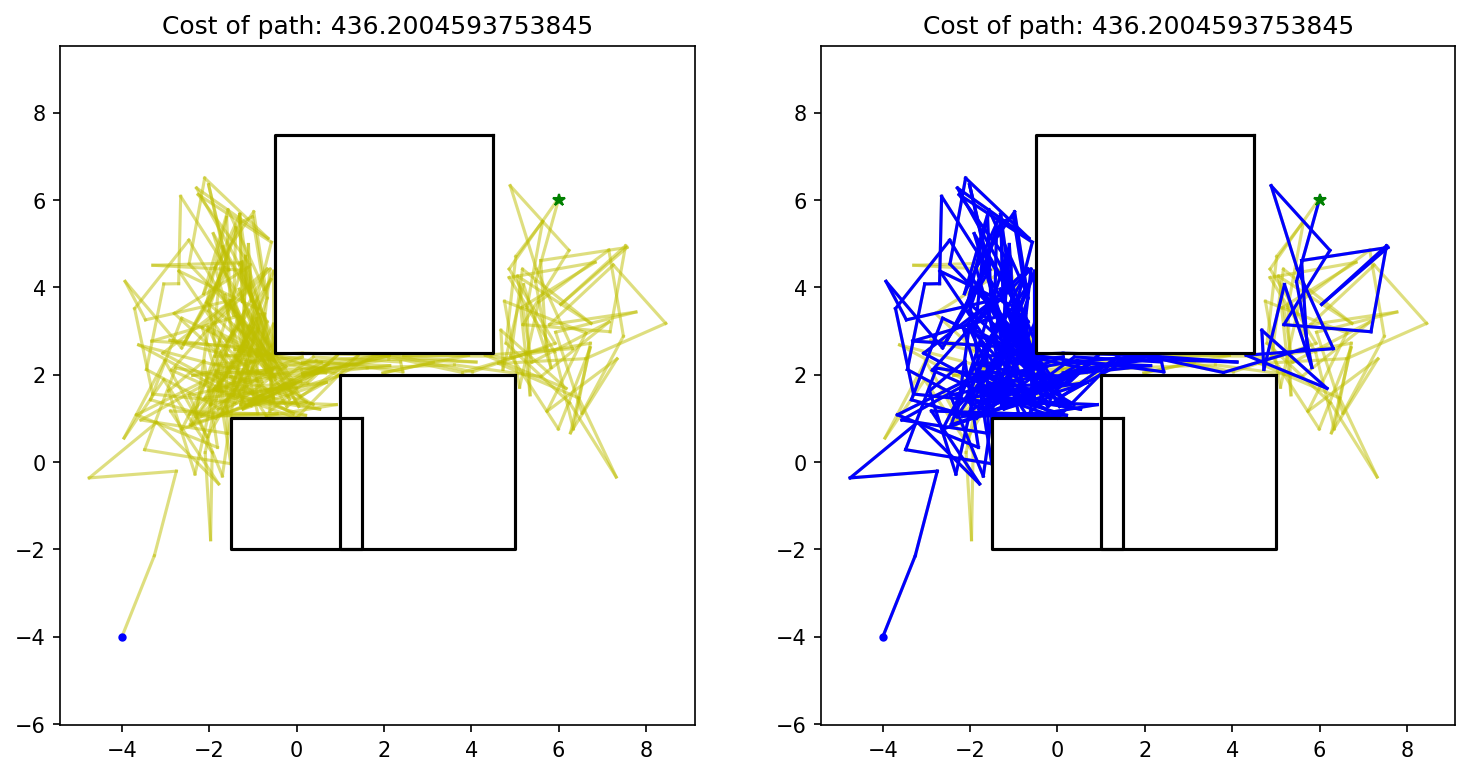

In [ ]:
# Plotting Code for the Random Link Chain
print("Random Link Chain")
num_iterations = 1000
links = generate_random_link_chain(start, goal, env_multi, region_x, region_y, 
                                   num_iterations, step_size)

print(f"Path Length (Iterations: {num_iterations}): {get_goal_path_length(goal, links, step_size)}")
plt.figure(figsize=(12, 6), dpi=150)
plt.subplot(121)
plot_environment_and_links(start, goal, env_multi, links, do_plot_goal_path=False)
plt.subplot(122)
plot_environment_and_links(start, goal, env_multi, links, do_plot_goal_path=True)

### P2.4.2: RRT

**TASK** Implement RRT! You may use the `generate_random_link_chain` as starter code. There is really only one place the code needs to change: instead of `latest_link`, you should select the link based on distance to the `point`.

**PLOTS** Run the RRT plotting code below, generating 4 plots in 1 figure that show the performance as a function of number of iterations. Include these plots in your writeup.

**QUESTION** (4-8 sentences) Describe the results and discuss the algorithmic properties of the algorithm. Is this planner *complete* (will it always eventually find a path to the goal)? Is it asymptotically optimal (will that path approach the shortest path in the limit of infinite samples)? How do your theoretical claims match up with the results (from your plots above)?

**CODE** Include a code block containing your finished RRT implementation in your writeup.

Path Length (Iterations: 100): 26.31012255828789
Path Length (Iterations: 500): 27.239939840704494
Path Length (Iterations: 2000): 27.470793394815708
Path Length (Iterations: 4000): 27.62794988794019


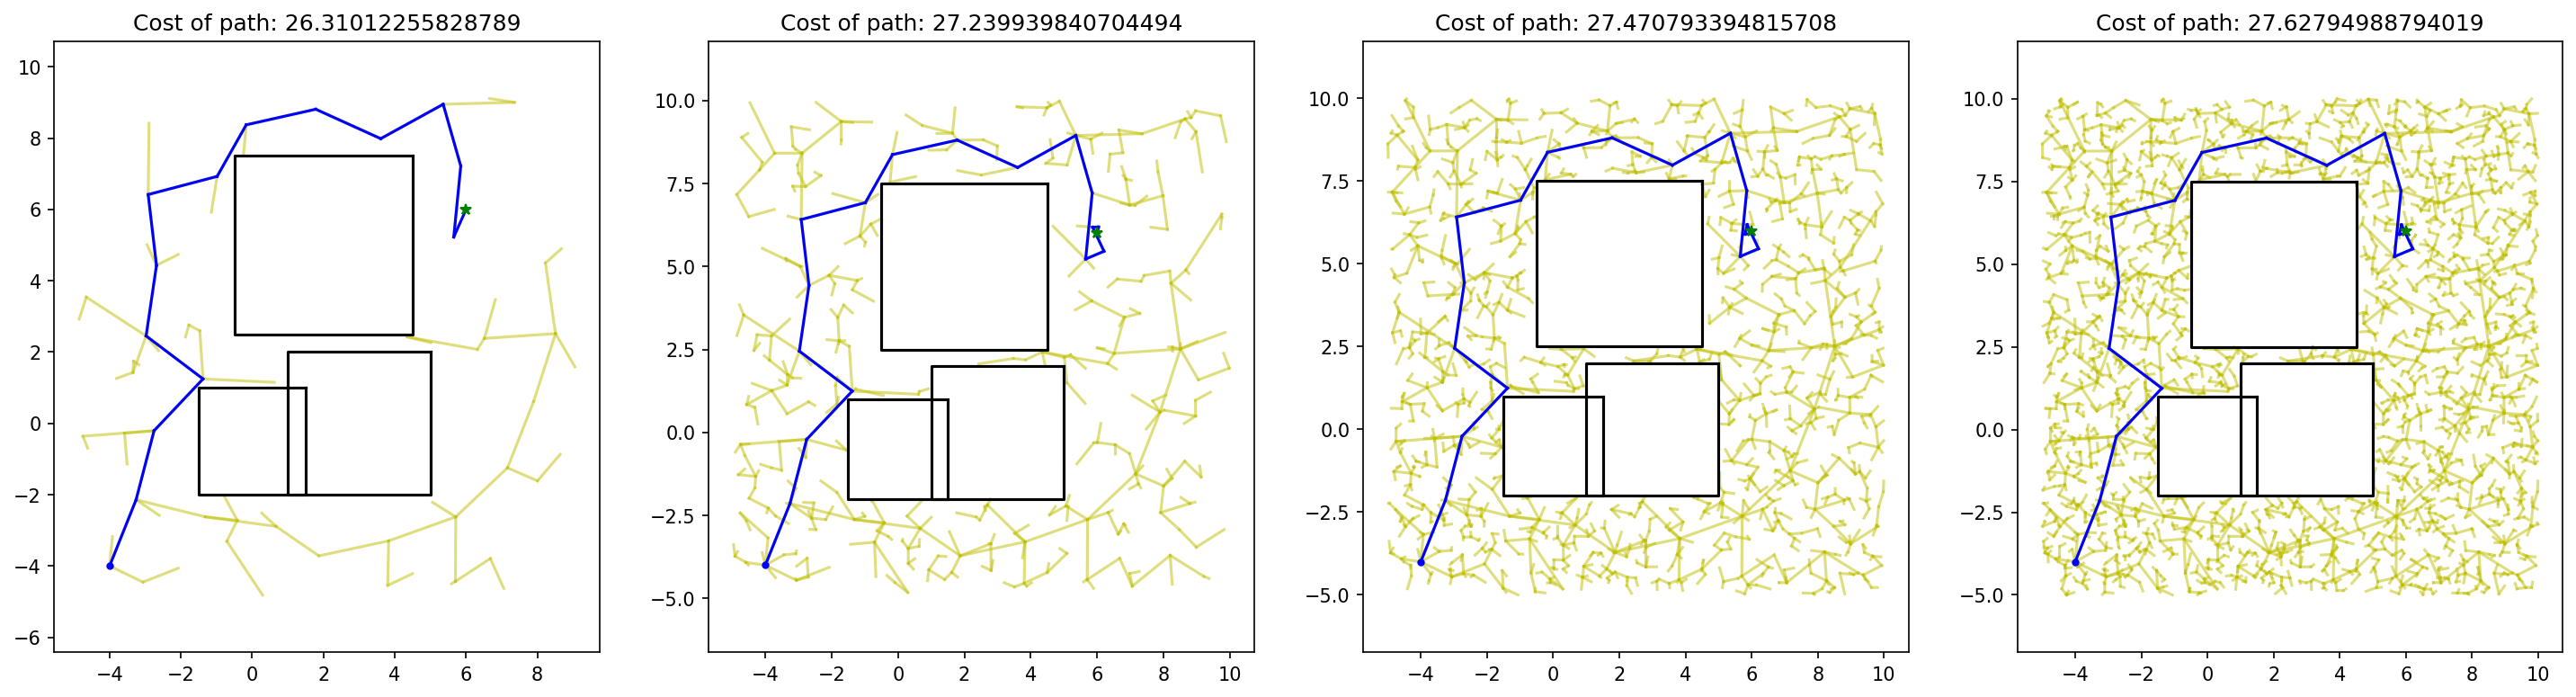

In [ ]:
# RRT Plotting code
def RRT(start, goal, obstacles, region_x, region_y, 
                               num_iterations, step_size, seed=695):
    random.seed(seed)
    links = [Link(start)]
    for _ in range(num_iterations):
        # Generate a random point
        px = random.uniform(region_x[0], region_x[1])
        py = random.uniform(region_y[0], region_y[1])
        point = [px, py]
    
        # Get the closest link
        min_dist = 2000.0
        nearest_link = links[-1]
        for link in links:
          dist1 = link.get_distance(point)
          if dist1 < min_dist:
            min_dist = dist1
            nearest_link = link

        # Steer towards it
        new_link, new_point = steer_towards_point(nearest_link, point, step_size)

        # If it collides, return
        if new_link.does_collide(obstacles):
            continue

        # Add to chain if it does not collide
        links.append(new_link)

    return links

def run_for_iterations(num_iterations):
    links = RRT(start, goal, env_multi, region_x, region_y, 
                num_iterations, step_size)
    print(f"Path Length (Iterations: {num_iterations}): {get_goal_path_length(goal, links, step_size)}")
    plot_environment_and_links(start, goal, env_multi, links, do_plot_goal_path=True)

plt.figure(figsize=(24, 6), dpi=150)
iterations = [100, 500, 2000, 4000]
for ii, num_iterations in enumerate(iterations):
    plt.subplot(1, len(iterations), ii + 1)
    run_for_iterations(num_iterations)

### P2.4.2: RRT*

**TASK** Implement RRT* (`RRTstar`)! Look through the lecture notes for implementation details. Every time you add a new point, you will need to loop through all links with points within `step_size` of the new point (each an `other_link`) and look for potential improvements: if you can extend your current link to the point of the `other_link` and that new link is shorter than the current path length of the other link, replace the upstream of that link to be the newer point you just added. [The lecture materials say this in more detail, though you will still need to think to get this right! One thing to realize here is that because the RRT* data forms a tree, you should never need to remove any points; you only need to change the upstream (and the costs associated with the link you're modifying).]

**PLOTS** Run the RRTstar plotting code below, generating 4 plots in 1 figure that show the performance as a function of number of iterations. Include these plots in your writeup.

**QUESTION** (4-8 sentences) Describe the results and discuss the algorithmic properties of the algorithm. Is this planner *complete* (will it always eventually find a path to the goal)? Is it asymptotically optimal (will that path approach the shortest path in the limit of infinite samples)? How do your theoretical claims match up with the results (from your plots above)?

**CODE** Include a code block containing your finished RRT* implementation in your writeup.

Path Length (Iterations: 100): 24.205382270208585
Path Length (Iterations: 500): 17.99492208913441
Path Length (Iterations: 2000): 15.848699772193154
Path Length (Iterations: 4000): 15.781310565027463


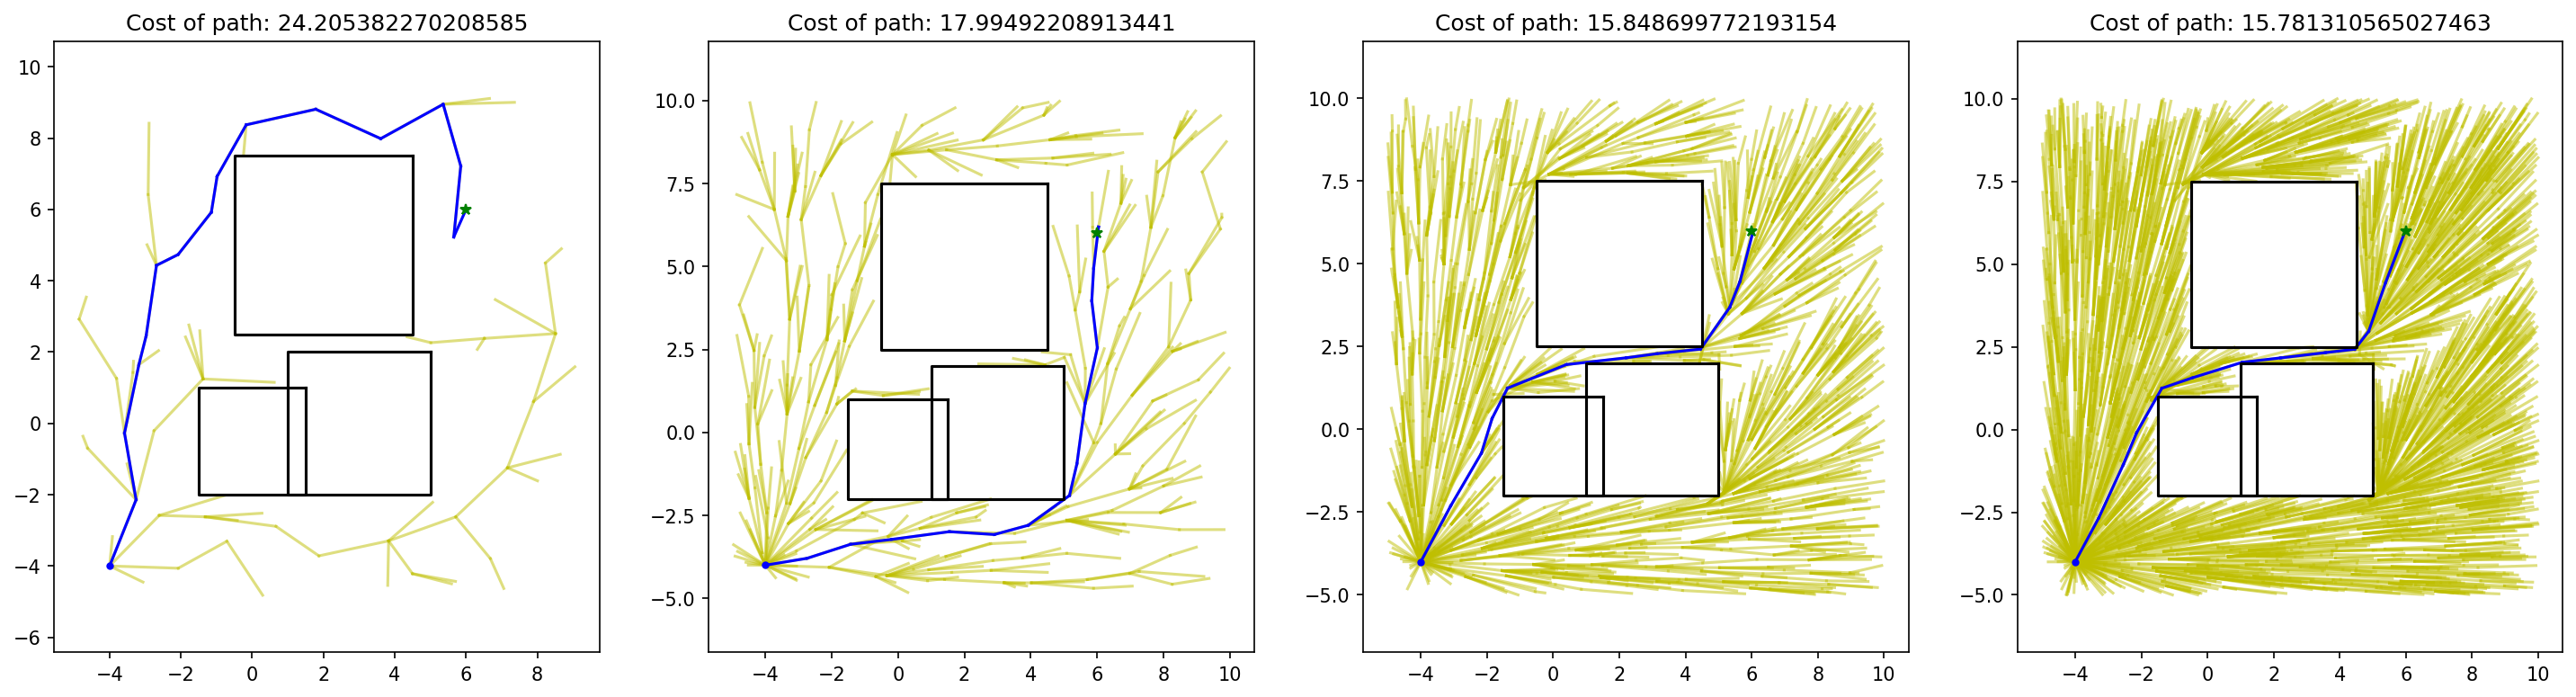

In [ ]:
# RRT* Plotting code
def RRTstar(start, goal, obstacles, region_x, region_y, 
                               num_iterations, step_size, seed=695):
    random.seed(seed)
    links = [Link(start)]
    for _ in range(num_iterations):
        # Generate a random point
        px = random.uniform(region_x[0], region_x[1])
        py = random.uniform(region_y[0], region_y[1])
        point = [px, py]
    
        # Get the closest link
        min_dist = 2000.0
        nearest_link = links[-1]
        for link in links:
          dist1 = link.get_distance(point)
          if dist1 < min_dist:
            min_dist = dist1
            nearest_link = link

        # Steer towards it
        new_link, new_point = steer_towards_point(nearest_link, point, step_size)

        # If it collides, return
        if new_link.does_collide(obstacles):
            continue

        # Add to chain if it does not collide
        links.append(new_link)
        # find the near points set
        points_near = []
        for link in links:
          dist1 = link.get_distance(point)
          if dist1 < step_size:
            points_near.append(link)
        
        min_cost = new_link.cost
        min_point = nearest_link
        # Adjust the new point's parent
        for point_near in points_near:
            line2 = LineString([new_point, point_near.point])
            cost = point_near.get_distance(new_point)
            # check collision
            if any(line2.intersects(obstacle) for obstacle in obstacles):
              continue
            else:   # Adjust the new point's parent
              if min_cost > point_near.cost + cost:
                min_point = point_near
                min_cost = point_near.cost + cost
        new_link.upstream = min_point
        new_link.geom_line = LineString([new_point, min_point.point])
        new_link.local_cost = min_point.get_distance(new_point)

        for point_near in points_near:
            line3 = LineString([new_point, point_near.point])
            cost = point_near.get_distance(new_point)
            # check collision
            if any(line3.intersects(obstacle) for obstacle in obstacles):
              continue
            else:   # Adjust the paths
              if point_near.cost > new_link.cost + cost:
                point_near.upstream = new_link
                point_near.geom_line = line3
                point_near.local_cost = cost

    return links

def run_for_iterations(num_iterations):
    links = RRTstar(start, goal, env_multi, region_x, region_y, 
                    num_iterations, step_size)
    print(f"Path Length (Iterations: {num_iterations}): {get_goal_path_length(goal, links, step_size)}")
    plot_environment_and_links(start, goal, env_multi, links, do_plot_goal_path=True)

plt.figure(figsize=(24, 6), dpi=150)
iterations = [100, 500, 2000, 4000]
for ii, num_iterations in enumerate(iterations):
    plt.subplot(1, len(iterations), ii + 1)
    run_for_iterations(num_iterations)
